[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/juanchess98/Notebooks-Deep-Learning/blob/transfer_learning/TL_CASO_1.ipynb)

# Transfer Learning (Enfoque por cuadrantes o escenarios usando Pytorch)

Aprender una tarea nueva puede ser un proceso que lleve una considerable cantidad de tiempo. Sin embargo, los seres humanos tienen la capacidad de asociar nuevas tareas con otras que ya sabe como ejecutar y aplicar este conocimiento para reducir el tiempo y costo de aprendizaje. Por ejemplo, si una persona sabe como manejar una bicicleta, para esa persona será mucho más fácil aprender a manejar una motocicleta. Asimismo, una persona que domine el idioma español tendrá mucha más facilidad para aprender otro idioma similar, como el portugués, que una persona de origen alemán o japonés.

Este mismo concepto se puede aplicar a las máquinas inteligentes y se le conoce como *Transfer Learning* o Aprendizaje por transferencia. En este caso, un modelo desarrollado para una resolver una tarea puede usarse como punto de partida para resolver otra tarea similar.

Pueden presentarse diferentes escenarios en la aplicación de *transferencia de aprendizaje* a un dataset nuevo, pero generalmente se puede reducir a cuatro casos:

1. La nueva base de datos es numerosa y se parece muy poco a la base de datos del modelo pre-entrenado
2. La nueva base de datos es numerosa y parecida a la base de datos del modelo pre-entrenado
3. La nueva base de datos es pequeña y diferente de la base de datos del modelo pre-entrenado
4. La nueva base de datos es pequeña y parecida a la base de datos del modelo pre-entrenado

En la siguiente gráfica tipo plano cartesiano pueden visualizarce mejor los posibles escenarios, dividiendo el plano en cuadrantes que representan cada escenario y dónde en la dirección de crecimiento del eje $x$ se indica la similaridad de los dos datasets y el eje $y$ el tamaño del nuevo dataset.

**(Insertar imagen de cuadrantes aquí)**

Para cada escenario existe una metodología diferente a implementar y en el curso de este notebook trataremos de ejemplificar cada una con la ayuda de los frameworks de Keras y Pytorch.

## Caso 1. La nueva base de datos es numerosa y diferente a la del modelo pre-entrenado

Si la nueva base de datos es grande y no se parece a la original, se recomienda seguir los siguientes pasos:

1. Quitar la última capa totalmente conectada y añadir una nueva capa totalmente conectada cuya dimensión de salida se igual al número de clases de la nueva base de datos.

2. Aleatorizar los pesos de la nueva capa totalmente conectada e inicializarlos con valores aleatorios

3. Entrenar la red para actualizar los pesos de la nueva capa totalmente conectada.


In [1]:
import time
import copy
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
from torchvision import datasets, models, transforms

### Cargar la base de datos DIFERENTE

In [2]:
'''torchvision.datasets.KMNIST(root: str, 
                            train: bool = True, 
                            transform: Optional[Callable] = None, 
                            target_transform: Optional[Callable] = None, 
                            download: bool = False)'''

transform = transforms.Compose(
            [transforms.Resize(size=32),
             transforms.Grayscale(num_output_channels=3),
             transforms.ToTensor(),
             transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]) # ((0.5), (0.5))]) #

batch_size = 4

image_datasets = {x: datasets.KMNIST(root='./kmnist_data', train=x=='train', 
                     download=True, transform=transform) for x in ['train', 'val']}

dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4, 
                                              shuffle=True, num_workers=2) for x in ['train', 'val']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}

class_names = image_datasets['train'].classes

print(class_names)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

['o', 'ki', 'su', 'tsu', 'na', 'ha', 'ma', 'ya', 're', 'wo']


#### Visualización de imágenes del nuevo dataset

La siguiente función la usamos para ver algunas de las imágenes de la nueva base de datos KMNIST y se imprime su respectiva etiqueta.

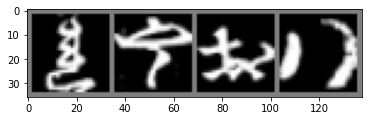

   re    ya     o    ha


In [3]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(dataloaders['train'])
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % class_names[labels[j]] for j in range(batch_size)))

In [4]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    model.to(device)

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):

                    outputs = model(inputs).to(device)

                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

### Paso 1. Cargar el modelo preentrenado

Se carga el modelo de la red VGG16 pre-entrenado con ImageNet al hacer 𝑝𝑟𝑒𝑡𝑟𝑎𝑖𝑛𝑒𝑑=𝑇𝑟𝑢𝑒. Nótese que las dimensiones de la última capa de salida son (4096, 1000), donde 1000 es el número de clases de la base de datos Imagenet.

In [5]:
from torchvision import datasets, models, transforms

In [6]:
pretrained_model = models.vgg16(pretrained=True)
pretrained_model.to(device)
pretrained_model.classifier

Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU(inplace=True)
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=4096, out_features=4096, bias=True)
  (4): ReLU(inplace=True)
  (5): Dropout(p=0.5, inplace=False)
  (6): Linear(in_features=4096, out_features=1000, bias=True)
)

### Paso 2. Congelar los pesos

Se congelan todos los pesos de la red pre-entrenada con $requires_grad = False$, esto impide que se calculen los gradientes en back-propagation.

In [7]:
for param in pretrained_model.parameters():
    param.requires_grad = False

### Paso 3. Agregar una nueva capa totalmente conectada

Se quita la última capa totalmente conectada del modelo pre-entrenado y se reemplaza por una capa nueva con dimensiones de salida (4096, 10), donde 10 es el número de clases de KMNIST.

Al agregar una nueva capa por defecto se tiene que $requires_autograd = True$,
dejamos este valor ya que queremos entrenar los pesos de esta capa.

In [8]:
criterion = nn.CrossEntropyLoss().to(device)
pretrained_model.classifier[6]= nn.Linear(4096, 10)
pretrained_model.classifier

Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU(inplace=True)
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=4096, out_features=4096, bias=True)
  (4): ReLU(inplace=True)
  (5): Dropout(p=0.5, inplace=False)
  (6): Linear(in_features=4096, out_features=10, bias=True)
)

### Paso 5.  Entrenar el modelo

In [9]:
optimizer_conv = optim.SGD(pretrained_model.classifier[6].parameters(), lr=0.001, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

In [10]:
pretrained_model = train_model(pretrained_model, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=2)

Epoch 0/1
----------


KeyboardInterrupt: 

### Visualizar el modelo y predecir

In [ ]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [ ]:
visualize_model(pretrained_model)

plt.ioff()
plt.show()